# Integration with LangChain

This notebook demonstrates how to use the WRITER ecosystem within LangChain, including setup, chat model usage, and tool invocation.

## Prerequisites

Before getting started, you'll need:

- A [Writer AI Studio](https://app.writer.com/register) account
- An API key, which you can obtain by following the [API Quickstart](https://dev.writer.com/api-guides/quickstart)


## 📦 Installation
Install the Writer integration package:

In [ ]:
%pip install langchain-writer

## 🔑 Setup API Key

Next, set the `WRITER_API_KEY` environment variable. We recommend setting it in a `.env` file in the root of your project, but this tutorial will set it in an environment variable if you don't have a `.env` file.

In [1]:
import os
import getpass

if not os.getenv("WRITER_API_KEY"):
    os.environ["WRITER_API_KEY"] = getpass.getpass("Enter your Writer API Key: ")


Enter your Writer API Key:  ········


Model

In [22]:
from langchain_writer import ChatWriter
from langchain_core.messages import SystemMessage, HumanMessage

model = ChatWriter(model="palmyra-x5")

## 🧠 Chat Model Usage

You've now installed the package and set up your WRITER API key.  
You can now use LangChain to create a chat with a Palmyra model.

The `model` argument in `ChatWriter` specifies which Palmyra model to use, such as `palmyra-x5`, `palmyra-general`, or domain-specific models. You can send structured messages using `SystemMessage` and `HumanMessage`.

> **Best practice:** Use a `SystemMessage` to define the assistant’s role, tone, and output structure. This helps generate more consistent and reliable results, especially when expecting structured JSON outputs.


In [23]:
sections_prompt = "Generate a blog outline for AI in healthcare."

response = model.invoke([
    SystemMessage(content="You are a blog planning assistant. Generate a structured blog plan based on the user's requirements. Respond with a JSON object containing a 'sections' array where each section has 'name', 'description', and 'main_body' fields."),
    HumanMessage(content=sections_prompt)
])

print(response.content)


Here is a structured blog plan on "AI in Healthcare" in JSON format:

```json
{
  "sections": [
    {
      "name": "Introduction to AI in Healthcare",
      "description": "Overview of AI's growing role in healthcare and its potential benefits",
      "main_body": "Artificial Intelligence (AI) is transforming the healthcare industry in numerous ways. From diagnosis to treatment, AI is being increasingly used to improve patient outcomes, streamline clinical workflows, and reduce costs. This blog post will explore the current state of AI in healthcare, its applications, benefits, and future prospects."
    },
    {
      "name": "Applications of AI in Healthcare",
      "description": "Exploring various use cases of AI in healthcare, including diagnosis, personalized medicine, and patient engagement",
      "main_body": "AI is being applied in various areas of healthcare, including medical imaging analysis, disease diagnosis, personalized medicine, and patient engagement. For instance, 

## 🚀 LangGraph Integration with ChatWriter

In this section, we'll demonstrate how to build a LangGraph agent using the `ChatWriter` model. We'll define tools, the agent's state, and construct the execution graph in a cookbook-friendly style.

### 📦 Step 1: Imports

We import LangChain and LangGraph essentials, including message types, tool decorators, and the graph framework. `Annotated` is used to manage state updates elegantly.

In [2]:
from langchain_writer import ChatWriter
from langchain.tools import tool
from langchain.messages import SystemMessage, HumanMessage, ToolMessage, AnyMessage
from typing_extensions import TypedDict, Annotated
import operator
from langgraph.graph import StateGraph, START, END

### 🛠 Step 2: Define Tools

Here we define a few basic arithmetic tools. In practice, you can define any callable as a tool. Using the `@tool` decorator allows LangGraph to recognize these as callable nodes in the execution graph.

> Tip: Keep tool interfaces simple and clearly typed to ensure the agent can call them correctly.

In [3]:
@tool
def add(a: int, b: int) -> int:
    """Return the sum of two integers."""
    return a + b

@tool
def multiply(a: int, b: int) -> int:
    """Return the product of two integers."""
    return a * b

@tool
def divide(a: int, b: int) -> float:
    """Return the result of dividing the first integer by the second."""
    return a / b


tools = [add, multiply, divide]
tools_by_name = {tool.name: tool for tool in tools}
model = ChatWriter(model="palmyra-x5")
model_with_tools = model.bind_tools(tools)


### 📊 Step 3: Define Agent State

LangGraph uses a structured `state` object to keep track of messages and other context. Using `Annotated` with `operator.add` ensures that new messages are appended rather than overwriting existing ones.

> Tip: You can extend the state with custom fields if your agent needs additional context.

In [4]:
class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]
    llm_calls: int

### 💬 Step 4: Define LLM Node

This node represents the LLM call. It decides if tools should be invoked based on the conversation context. The returned dictionary updates the agent state.

> Tip: Keep system instructions clear to guide the LLM on how to handle tool calls and responses.

In [5]:
def llm_call(state: dict):
    return {
        "messages": [
            model_with_tools.invoke([
                SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
            ] + state["messages"])
        ],
        "llm_calls": state.get("llm_calls", 0) + 1
    }

### 🛠 Step 5: Define Tool Node

The tool node executes any tool calls made by the LLM. Each tool call produces a `ToolMessage` which is appended to the agent state.

In [6]:
def tool_node(state: dict):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}

### 🔁 Step 6: Define Conditional Edge

This function controls the flow of the graph. If the LLM has requested a tool call, the agent proceeds to the tool node; otherwise, it ends.

In [7]:
from typing import Literal
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tool_node"
    return END

### 🏗 Step 7: Build and Compile Agent

Now we assemble the graph, add nodes, define edges, and compile the agent.

> Tip: You can visualize this graph before compilation to debug the flow of nodes and edges.

In [15]:
agent_builder = StateGraph(MessagesState)
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges("llm_call", should_continue, ["tool_node", END])
agent_builder.add_edge("tool_node", "llm_call")

agent = agent_builder.compile()

### 🖼 Step 8: Visualize

Use the built-in graph visualization to see the execution flow. This is especially helpful for complex agents with many nodes.

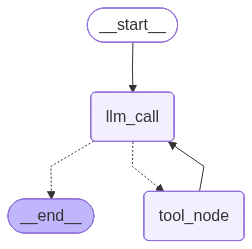

In [16]:
from IPython.display import Image, display
display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

### Step 9: Test Agent

Send a test message to your agent and print the results. Each message returned can be pretty-printed for readability.

In [17]:
messages = [HumanMessage(content="Add 3 and 4.")]
messages = agent.invoke({"messages": messages}, {"recursion_limit": 7})
for m in messages["messages"]:
    m.pretty_print()

# messages = agent.invoke({"messages": [{"role": "user", "content": "Add 3 and 4."}]}, {"recursion_limit": 7})
# for m in messages["messages"]:
#     m.pretty_print()

================================ Human Message =================================

Add 3 and 4.
================================== Ai Message ==================================
Tool Calls:
  add (call_yknp411qx3er0ohtgno9kvgn)
 Call ID: call_yknp411qx3er0ohtgno9kvgn
  Args:
    a: 3
    b: 4
================================= Tool Message =================================

7
================================== Ai Message ==================================

The result of adding 3 and 4 is 7.


# DeepAgents with ChatWriter and Web Search

This notebook demonstrates how to build a deep agent using `ChatWriter` and Writer's Web Search tool to perform real-time research and generate reports.

### 📦 Step 1: Imports

We import `ChatWriter`, `create_deep_agent`, and message types.

In [ ]:
%pip install deepagents

In [18]:
from langchain_writer import ChatWriter
from langchain_core.messages import SystemMessage, HumanMessage
from deepagents import create_deep_agent

### 🛠 Step 2: Initialize the Model and Writer Client

Assumes `WRITER_API_KEY` is already set in the environment.

### 🔍 Step 3: Define Web Search Tool

The tool configuration tells the agent how to use the Writer Web Search functionality.

In [19]:
tools = [{
    "type": "web_search",
    "function": {
        "include_domains": ["www.ibm.com/quantum"],  # Optional: restrict to certain domains
        # "exclude_domains": []   # Optional: exclude domains
    }
}]

### 🤖 Step 4: Create Deep Agent

We use `create_deep_agent` with the ChatWriter model and the Web Search tool.

In [20]:
system_prompt = '''
You are an expert researcher. Your job is to answer questions accurately and provide references.
You have access to the Web Search tool to retrieve up-to-date information from the internet.
'''

agent = create_deep_agent(
    model=model,
    tools=tools,
    system_prompt=system_prompt
)

### 🏃 Step 5: Run the Agent with a Query

Send a research question to the agent and get a response using Web Search.

In [21]:
result = agent.invoke({"messages": [{"role": "user", "content": "Find recent breakthroughs in quantum computing. Include references from at most 3 sources."}]})
print(result['messages'][-1].content)

Recent breakthroughs in quantum computing include the development of a new quantum algorithm by IBM researchers, which demonstrates a substantial speedup over the best classical methods. This algorithm exploits a connection between quantum physics and mathematics, specifically group theory and the non-Abelian Fourier transform. The algorithm has the potential to provide inroads toward answering long-open questions in mathematics and has been shown to be efficient on some subsets of inputs.

Additionally, IBM has made significant advancements in building a fault-tolerant quantum computer. They have detailed a rigorous end-to-end framework for a fault-tolerant quantum computer that is modular and based on bivariate bicycle codes. This framework includes a new error correction decoder called Relay-BP, which achieves a 5x-10x reduction over other leading decoders.

IBM has also been working on advancing its quantum hardware, with the fabrication of quantum chips at the Albany NanoTech Comp